In [84]:
import numpy as np 
import pandas as pd 
import os
import cv2
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

## Labels

In [85]:
labels = os.listdir(r"archive\train")

In [86]:
labels

['Closed', 'no_yawn', 'Open', 'yawn']

## Visualize A random image

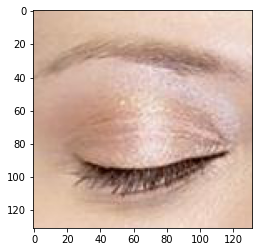

In [4]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(r"archive\train\Closed\_2.jpg"))

# Yawn or No Yawn

In [89]:
def face_for_yawn(direc=r"archive\train", face_cas_path=r"data\haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


## For Closed and Open eye

In [92]:
def get_data(dir_path=r"archive\train"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num+=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [93]:
data_train = get_data()

2
3


## Extend data and Convert array

In [95]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

## New variable to store

In [96]:
new_data = append_data()

0
1
2
3


C:\Users\anlog\AppData\Local\Temp\ipykernel_7244\2804427426.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


## Separate label and features

In [97]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

## Reshape the Array

In [98]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

## LabelBinarizer

In [99]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

## Label array

In [100]:
y = np.array(y)

## Train Test split

In [101]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## Length of X_test

In [102]:
len(X_test)

578

## Data Augmentation

In [103]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=20)
test_generator = ImageDataGenerator(rescale=1/255)


#train_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_generator = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [106]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(32, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d_91 (MaxPoolin  (None, 71, 71, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_92 (Conv2D)          (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_92 (MaxPoolin  (None, 34, 34, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_93 (MaxPoolin  (None, 16, 16, 64)     

In [107]:
history = model.fit(train_generator, epochs=25, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/25
43/43 [==============================] - 74s 2s/step - loss: 1.1270 - accuracy: 0.5100 - val_loss: 0.4837 - val_accuracy: 0.8097
Epoch 2/25
43/43 [==============================] - 74s 2s/step - loss: 0.4554 - accuracy: 0.8159 - val_loss: 0.3831 - val_accuracy: 0.8183
Epoch 3/25
43/43 [==============================] - 73s 2s/step - loss: 0.3374 - accuracy: 0.8708 - val_loss: 0.3028 - val_accuracy: 0.8824
Epoch 4/25
43/43 [==============================] - 76s 2s/step - loss: 0.2940 - accuracy: 0.8790 - val_loss: 0.2202 - val_accuracy: 0.9066
Epoch 5/25
43/43 [==============================] - 74s 2s/step - loss: 0.2377 - accuracy: 0.9050 - val_loss: 0.2186 - val_accuracy: 0.9170
Epoch 6/25
43/43 [==============================] - 80s 2s/step - loss: 0.2063 - accuracy: 0.9131 - val_loss: 0.1882 - val_accuracy: 0.9204
Epoch 7/25
43/43 [==============================] - 76s 2s/step - loss: 0.1887 - accuracy: 0.9287 - val_loss: 0.2001 - val_accuracy: 0.9100
Epoch 8/25
43/43 [==

## History

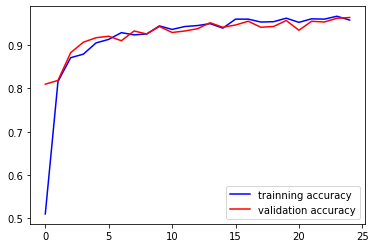

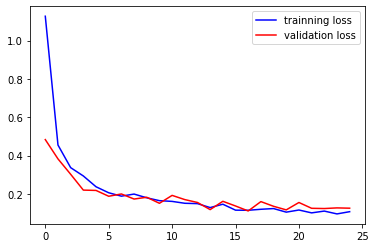

In [108]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

## Save Model

In [111]:
model.save("drowiness_DetectionH5.h5")

In [112]:
model.save("drowiness_DetectionH5.model")

INFO:tensorflow:Assets written to: drowiness_DetectionH5.model\assets


# Prediction

In [113]:
prediction = np.argmax(model.predict(X_test), axis=1)

In [114]:
prediction

array([3, 3, 2, 3, 1, 3, 3, 2, 1, 2, 3, 3, 3, 2, 2, 2, 3, 1, 0, 3, 0, 3,
       2, 1, 1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 0, 3, 3, 2, 1, 3, 3, 3, 2, 3,
       2, 2, 3, 3, 3, 3, 3, 2, 2, 1, 3, 3, 2, 2, 2, 0, 3, 3, 1, 2, 2, 3,
       2, 3, 2, 2, 1, 3, 3, 3, 2, 0, 1, 3, 1, 3, 2, 0, 3, 2, 2, 2, 2, 1,
       3, 3, 2, 3, 3, 3, 1, 0, 3, 0, 3, 3, 3, 1, 3, 1, 2, 3, 2, 1, 2, 2,
       1, 1, 2, 1, 0, 3, 3, 3, 2, 2, 3, 3, 2, 1, 1, 2, 3, 3, 2, 0, 3, 3,
       1, 3, 1, 2, 3, 3, 2, 1, 2, 2, 2, 1, 3, 3, 2, 3, 2, 0, 3, 3, 3, 3,
       3, 0, 1, 0, 3, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 2, 0, 3, 3,
       3, 3, 0, 2, 3, 0, 2, 1, 3, 2, 3, 1, 2, 1, 1, 3, 2, 2, 3, 3, 3, 0,
       3, 2, 3, 0, 2, 0, 0, 1, 2, 3, 2, 0, 3, 1, 2, 2, 2, 2, 1, 3, 1, 1,
       1, 2, 2, 3, 3, 3, 3, 0, 1, 2, 0, 0, 3, 3, 2, 3, 3, 0, 3, 3, 0, 1,
       0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 0, 2, 2, 2, 0, 3, 3, 2, 2,
       3, 2, 2, 0, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 0, 3, 3, 3, 3, 2,
       2, 1, 2, 2, 2, 3, 3, 0, 2, 2, 3, 3, 2, 3, 1,

# classification report

In [115]:
labels_new = ["yawn","no_yawn","Closed","Open"]

In [116]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.95      0.83      0.88        63
     no_yawn       0.85      0.95      0.90        74
      Closed       0.96      0.95      0.96       215
        Open       0.96      0.97      0.96       226

    accuracy                           0.94       578
   macro avg       0.93      0.92      0.93       578
weighted avg       0.95      0.94      0.94       578



# predicting function

In [118]:
labels_new = ["yawn", "no_yawn","Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = (img_array/255)
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_DetectionH5.h5")

# Prediction 
## 0-Yawn 1-No Yawn 2-Closed, 3-Open

In [120]:
# prepare("../input/drowsiness-dataset/train/no_yawn/1068.jpg")
prediction = model.predict([prepare(r"archive\train\no_yawn\1067.jpg")])
np.argmax(prediction)

1

In [124]:
prediction = model.predict([prepare(r"archive\train\yawn\57.jpg")])
np.argmax(prediction)

3

In [125]:
prediction = model.predict([prepare(r"archive\train\Closed\_104.jpg")])
np.argmax(prediction)

2

In [127]:
prediction = model.predict([prepare(r"archive\train\Open\_98.jpg")])
np.argmax(prediction)


3